## Supervised and Unsupervised Learning for Country Classification (This file needs to needs to be updated)
### Dataset used: Poverty headcount ratio
##### Link to download : http://data.un.org/Data.aspx?d=WDI&f=Indicator_Code%3aSI.POV.DDAY


In [1]:
#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap

# libraries for computation
import pandas as pd
import numpy as np

#library for train test split
from sklearn.model_selection import train_test_split,cross_val_score,KFold

#library for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#library for Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#Library for feature selection techniques
from sklearn.feature_selection import RFE

#libraries for various ML models 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
#ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#Libraries for Unsupervised learning
from sklearn.cluster import KMeans,AgglomerativeClustering

#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Utility Method to plot confusion matrix
def plotConfusionMatrix(cm):
    sns.set_style('white')
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
    classNames = ['Developed','Developing']
    plt.title('Confusion Matrix',fontsize = 15)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames,fontsize=12)
    plt.yticks(tick_marks, classNames,fontsize=12)
    s = [['TP','FN'], ['FP', 'TN']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

### Read Data from CSV

In [3]:
# Read data from csv and print the head
data = pd.read_csv('Poverty.csv')
data.head(5)

Country or Area  Year  Value  Value Footnotes
0         Albania  2012    1.1              1.0
1         Albania  2008    0.4              1.0
2         Albania  2005    1.1              1.0
3         Albania  2002    2.0              1.0
4         Albania  1996    1.1              1.0

#### lets drop extra column Value Footnotes

In [4]:
# Read data from csv and print the head
data = data.drop(columns=['Value Footnotes'])
data.head(5)

Country or Area  Year  Value
0         Albania  2012    1.1
1         Albania  2008    0.4
2         Albania  2005    1.1
3         Albania  2002    2.0
4         Albania  1996    1.1

#### Get data insights

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Data columns (total 3 columns):
Country or Area    1614 non-null object
Year               1614 non-null object
Value              1602 non-null float64
dtypes: float64(1), object(2)
memory usage: 37.9+ KB


#### It seems Value column has some null or Nan values

In [6]:
vals = data['Value']
d = data[ vals.isna() ]
d

Country or Area                                               Year  Value
1602   footnoteSeqID                                           Footnote    NaN
1603               1       Estimated from unit-record consumption data.    NaN
1604               2           Estimated from grouped consumption data.    NaN
1605               3  Estimated from unit-record income data. Urban ...    NaN
1606               4  Estimated from grouped income data. Urban only...    NaN
1607               5            Estimated from unit-record income data.    NaN
1608               6                Estimated from grouped income data.    NaN
1609               7  Estimated from grouped consumption data. Natio...    NaN
1610               8  Retrieved on Sept 19, 2018 from World Bank, Po...    NaN
1611               9  Estimated from unit-record consumption data. P...    NaN
1612              10  Estimated from grouped consumption data. PPP i...    NaN
1613              12  Estimated from unit-record consumption data. N...    NaN

##### lets drop this rows

In [7]:
data  = data [0:1602] 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 3 columns):
Country or Area    1602 non-null object
Year               1602 non-null object
Value              1602 non-null float64
dtypes: float64(1), object(2)
memory usage: 37.6+ KB


In [8]:
#lets check number of unique countries we have in dataset
data['Country or Area'].nunique()

175

### Lets normalize data

In [9]:
# Normalize the value column and drop old column

# Create x, where x the 'Value' column's values as floats
x = data[['Value']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)
df_normalized['normalized'] = pd.DataFrame(x_scaled)
df_normalized.drop(columns=0,inplace=True)

data_new = pd.concat([data,df_normalized ], axis=1)
data_new.drop(columns='Value',inplace=True)

In [10]:
# Check new dataframe with normalized value
data_new.head()

Country or Area  Year  normalized
0         Albania  2012    0.011690
1         Albania  2008    0.004251
2         Albania  2005    0.011690
3         Albania  2002    0.021254
4         Albania  1996    0.011690

#### Using tsfresh to extract features from data

In [11]:
# Use TSFresh library to extract features from data 
from tsfresh import extract_features
extracted_features = extract_features(data_new, column_id="Country or Area", column_sort="Year")

Feature Extraction: 100%|██████████| 10/10 [00:12<00:00,  1.03s/it]


In [12]:
#Check extracted features
extracted_features.head()

variable   normalized__abs_energy  normalized__absolute_sum_of_changes  \
id                                                                       
Albania                  0.000880                             0.034006   
Algeria                  0.008731                             0.063762   
Angola                   0.220140                             0.023379   
Argentina                0.063581                             0.308183   
Armenia                  0.129814                             0.243358   

variable   normalized__agg_autocorrelation__f_agg_"mean"  \
id                                                         
Albania                                        -0.207301   
Algeria                                        -0.662088   
Angola                                         -1.000000   
Argentina                                       0.080516   
Armenia                                        -0.419327   

variable   normalized__agg_autocorrelation__f_agg_"median"  \
id                                                           
Albania                                          -0.009288   
Algeria                                          -0.662088   
Angola                                           -1.000000   
Argentina                                         0.120244   
Armenia                                          -0.443550   

variable   normalized__agg_autocorrelation__f_agg_"var"  \
id                                                        
Albania                                        0.123878   
Algeria                                        0.236452   
Angola                                         0.000000   
Argentina                                      0.337182   
Armenia                                        0.443094   

variable   normalized__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"  \
id                                                                                     
Albania                                                  NaN                           
Algeria                                                  NaN                           
Angola                                                   NaN                           
Argentina                                           0.085724                           
Armenia                                             0.205101                           

variable   normalized__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"  \
id                                                                                  
Albania                                                  NaN                        
Algeria                                                  NaN                        
Angola                                                   NaN                        
Argentina                                          -0.164281                        
Armenia                                            -1.000000                        

variable   normalized__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"  \
id                                                                                 
Albania                                                  NaN                       
Algeria                                                  NaN                       
Angola                                                   NaN                       
Argentina                                          -0.010627                       
Armenia                                            -0.180659                       

variable   normalized__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"  \
id                                                                                  
Albania                                                  NaN                        
Algeria                                                  NaN                        
Angola                                                   NaN         

In [13]:
#Check shape of new data with extracted features
extracted_features.shape

(175, 794)

In [14]:
#Check if any columns contains Nan values (null values)
list_cols_with_nan = extracted_features.columns[extracted_features.isna().any()].tolist()
len(list_cols_with_nan)

568

In [15]:
# it seems 552 columns out of 794 have some null values

In [16]:
#lets replace nan value with 0.0
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
data_after_impute = impute(extracted_features)

 'normalized__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'normalized__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'normalized__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'normalized__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'normalized__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'normalized__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'normalized__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'normalized__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'normalized__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'normalized__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'normalized__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'normalized__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'normalized__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'normalized__agg_linear_tre

In [17]:
#lets check if any column has any nan value
list_cols_with_nan_after_impute = data_after_impute.columns[data_after_impute.isna().any()].tolist()
len(list_cols_with_nan_after_impute)

0

In [18]:
#we dont have any nan values 
# lets reset the index
data_after_impute = data_after_impute.reset_index()

In [19]:
# we need to give labels to countries 
data_countries = pd.read_excel('Developing countries.xlsx')

developed_countries = data_countries [data_countries['Value'] == 0]
developing_countries = data_countries [data_countries['Value'] == 1] 

list_developed_countries = developed_countries['Countries']
list_developing_countries = developing_countries['Countries']

list_developed_countries = list(list_developed_countries)
list_developing_countries = list(list_developing_countries)

data_after_impute['label'] = -1

for i,da in data_after_impute.iterrows():
    if da['id'] in list_developed_countries:
        val = 0
        data_after_impute.at[i,'label'] = val
    elif da['id'] not in list_developed_countries:
        val = 1
        data_after_impute.at[i,'label'] = val

In [20]:
# check new df with added column as label 
data_after_impute.head()

variable         id  normalized__abs_energy  \
0           Albania                0.000880   
1           Algeria                0.008731   
2            Angola                0.220140   
3         Argentina                0.063581   
4           Armenia                0.129814   

variable  normalized__absolute_sum_of_changes  \
0                                    0.034006   
1                                    0.063762   
2                                    0.023379   
3                                    0.308183   
4                                    0.243358   

variable  normalized__agg_autocorrelation__f_agg_"mean"  \
0                                             -0.207301   
1                                             -0.662088   
2                                             -1.000000   
3                                              0.080516   
4                                             -0.419327   

variable  normalized__agg_autocorrelation__f_agg_"median"  \
0                                               -0.009288   
1                                               -0.662088   
2                                               -1.000000   
3                                                0.120244   
4                                               -0.443550   

variable  normalized__agg_autocorrelation__f_agg_"var"  \
0                                             0.123878   
1                                             0.236452   
2                                             0.000000   
3                                             0.337182   
4                                             0.443094   

variable  normalized__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"  \
0                                                  0.103082                           
1                                                  0.103082                           
2                                                  0.103082                           
3                                                  0.085724                           
4                                                  0.205101                           

variable  normalized__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"  \
0                                                 -1.000000                        
1                                                 -1.000000                        
2                                                 -1.000000                        
3                                                 -0.164281                        
4                                                 -1.000000                        

variable  normalized__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"  \
0                                                 -0.056323                       
1                                                 -0.056323                       
2                                                 -0.056323                       
3                                                 -0.010627                       
4                                                 -0.180659                       

variable  normalized__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"  \
0                                                  0.000000                        
1                                                  0.000000                        
2                                                  0.000000                        
3                                                  0.063809                        
4                                                  0.000000                        

variable  ...    normalized__time_reversal_asymmetry_statistic__lag_2  \
0         ...                                         0.000000e+00      
1         ...                                         0.000000e+00      
2         ...                                         0.000000e+00      
3         ...              

In [21]:
#Split data into X(features),y 
y = data_after_impute['label']
X = data_after_impute.drop(columns=['id','label'])
y.value_counts()

1    142
0     33
Name: label, dtype: int64

In [22]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

## Supervised learning techniques

#### Support Vector Machine

In [23]:
clf = svm.SVC(gamma='auto',C=10,kernel='rbf')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))

Area Under Curve:  0.5769230769230769


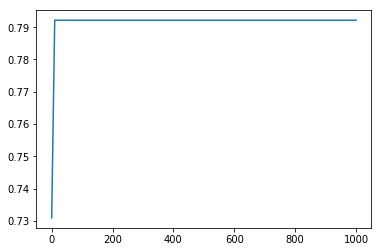

In [24]:
#SVM Fine tunning
cVals = [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]
f1_scores = []
for c in cVals:
    clf = svm.SVC(gamma='auto',C=c,kernel='rbf')
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(cVals,f1_scores)

#### Output with best parameters for SVM

Area Under Curve:  0.5769230769230769
              precision    recall  f1-score   support

           0       1.00      0.15      0.27        13
           1       0.84      1.00      0.91        57

   micro avg       0.84      0.84      0.84        70
   macro avg       0.92      0.58      0.59        70
weighted avg       0.87      0.84      0.79        70



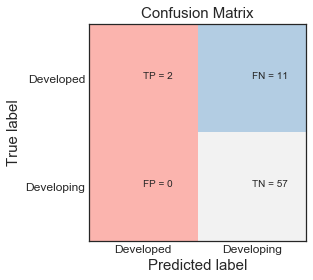

In [25]:
clf = svm.SVC(gamma='auto',C=10,kernel='rbf')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Logistic Regression

Area Under Curve:  0.8319838056680162
              precision    recall  f1-score   support

           0       0.62      0.77      0.69        13
           1       0.94      0.89      0.92        57

   micro avg       0.87      0.87      0.87        70
   macro avg       0.78      0.83      0.80        70
weighted avg       0.89      0.87      0.88        70



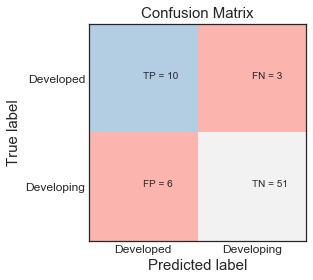

In [26]:
#Logistic Regression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
pred = logmodel.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

###### KNN with k ranging from 1 to 15

Text(0.5,0,'K values')

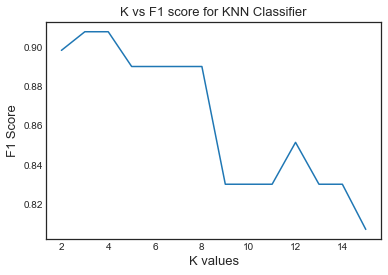

In [27]:
#KNN for different k values
kVals = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []

for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(kVals,scores)
plt.title('K vs F1 score for KNN Classifier',fontsize = 13)
plt.ylabel('F1 Score',fontsize=13)
plt.xlabel('K values',fontsize=13)

#### Output with best value of K

Area Under Curve:  0.7989203778677463
              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.92      0.98      0.95        57

   micro avg       0.91      0.91      0.91        70
   macro avg       0.90      0.80      0.84        70
weighted avg       0.91      0.91      0.91        70



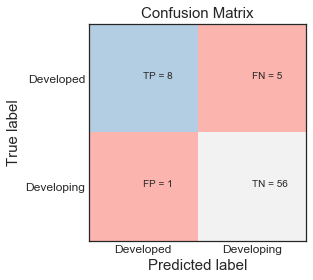

In [27]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Decision Tree Classifier

Area Under Curve:  0.8846153846153846
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.95      1.00      0.97        57

   micro avg       0.96      0.96      0.96        70
   macro avg       0.97      0.88      0.92        70
weighted avg       0.96      0.96      0.95        70



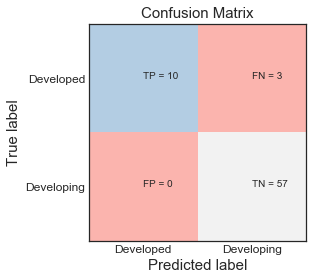

In [29]:
#DT
d_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
d_classifier.fit(X_train,y_train)
pred = d_classifier.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Bagging Classifier with Decision Tree as base estimator

[0.9215686274509802, 0.9409688013136287, 0.9386308606647591, 0.9409688013136287, 0.9079462909971385, 0.9079462909971385, 0.9079462909971385, 0.9248287943940117, 0.9248287943940117, 0.9386308606647591, 0.9248287943940117, 0.9248287943940117]


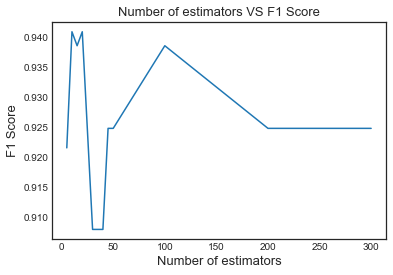

In [32]:
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    cart = DecisionTreeClassifier()
    model = BaggingClassifier(base_estimator=cart, n_estimators=e, random_state=7)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

Area Under Curve:  0.875843454790823
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.95      0.98      0.97        57

   micro avg       0.94      0.94      0.94        70
   macro avg       0.93      0.88      0.90        70
weighted avg       0.94      0.94      0.94        70



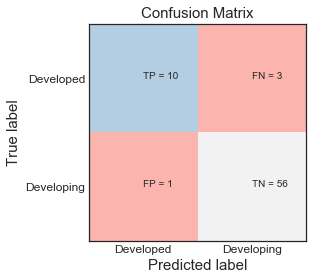

In [37]:
#Bagging Classifier with Decision tree as base learner
cart = DecisionTreeClassifier()
model = BaggingClassifier(base_estimator=cart, n_estimators=10, random_state=7)
model.fit(X_train, y_train)
pred = model.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Random Forest Classifier

#### Fine tuninng Random Forest for different number of estimators

[0.9079462909971385, 0.9248287943940117, 0.8901960784313725, 0.9114532019704433, 0.9409688013136287, 0.9248287943940117, 0.9409688013136287, 0.9248287943940117, 0.9248287943940117, 0.9248287943940117, 0.9248287943940117, 0.9248287943940117]


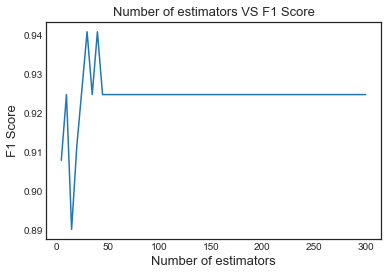

In [34]:
#Ensemble Random Forest Classifier Fine Tunning
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    rf_classifier = RandomForestClassifier(n_estimators=e, random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### Lets fine tune for number of features with best number of estimator from above analysis

In [31]:
rf_classifier = RandomForestClassifier(n_estimators=30, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))

Area Under Curve:  0.875843454790823


[0.9248287943940117, 0.9114532019704433, 0.9248287943940117, 0.9114532019704433, 0.9248287943940117, 0.8947603121516164, 0.9409688013136287, 0.9386308606647591, 0.9386308606647591, 0.9248287943940117, 0.9248287943940117]


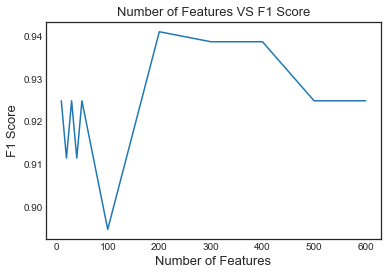

In [37]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    rf_classifier = RandomForestClassifier(max_features = e ,n_estimators=30,random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores)
plt.title("Number of Features VS F1 Score",fontsize = 13)
plt.xlabel('Number of Features',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### RFC with Best Parameters

In [32]:
rf_classifier = RandomForestClassifier(n_estimators=30,max_features=200, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))

Area Under Curve:  0.875843454790823
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.95      0.98      0.97        57

   micro avg       0.94      0.94      0.94        70
   macro avg       0.93      0.88      0.90        70
weighted avg       0.94      0.94      0.94        70



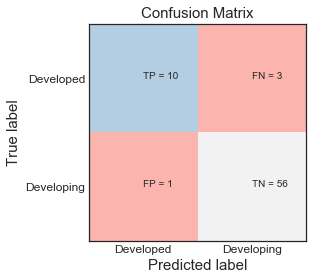

In [33]:
plotConfusionMatrix(confusion_matrix(y_test,pred))

### Extra tree classifier

###### Fine tune for number of estimators

[0.9079462909971385, 0.8947603121516164, 0.9079462909971385, 0.8947603121516164, 0.9386308606647591, 0.9386308606647591, 0.9248287943940117, 0.9248287943940117, 0.9248287943940117, 0.9248287943940117, 0.9248287943940117, 0.9386308606647591]


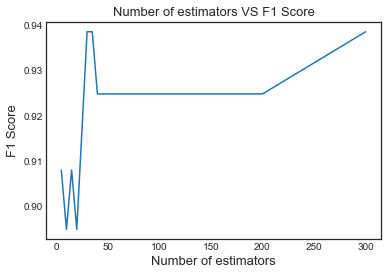

In [40]:
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    model = ExtraTreesClassifier(n_estimators=e,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

In [34]:
model = ExtraTreesClassifier(n_estimators=30,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))

Area Under Curve:  0.8461538461538461


#### fine tune for max_features

[0.9386308606647591, 0.9079462909971385, 0.9248287943940117, 0.9386308606647591, 0.9114532019704433, 0.9114532019704433, 0.9215686274509802, 0.9215686274509802, 0.9248287943940117, 0.8901960784313725, 0.9114532019704433]


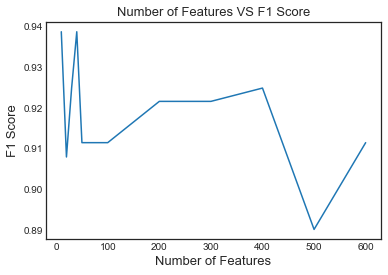

In [45]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    model = ExtraTreesClassifier(max_features=e,n_estimators=30,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores) 
plt.title("Number of Features VS F1 Score",fontsize = 13)
plt.xlabel('Number of Features',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### Best ExtraTree Classifier

In [35]:
model = ExtraTreesClassifier(n_estimators=30,max_features=10,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))

Area Under Curve:  0.8461538461538461
              precision    recall  f1-score   support

           0       1.00      0.69      0.82        13
           1       0.93      1.00      0.97        57

   micro avg       0.94      0.94      0.94        70
   macro avg       0.97      0.85      0.89        70
weighted avg       0.95      0.94      0.94        70



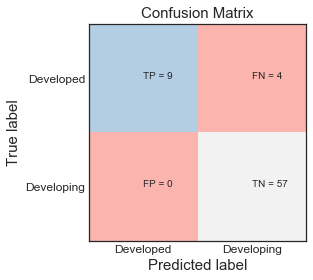

In [36]:
plotConfusionMatrix(confusion_matrix(y_test,pred))

### Treating problem as Unsupervised learning

In [51]:
y = data_after_impute['label']
X = data_after_impute.drop(columns=['id','label'])

### K-Means Clustering

             precision    recall  f1-score   support

          0       0.19      1.00      0.32        33
          1       1.00      0.01      0.01       142

avg / total       0.85      0.19      0.07       175



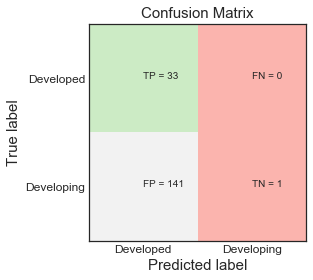

In [52]:
#Build model for k-means clustering
model = KMeans(n_clusters=2,n_init=400,random_state=42,max_iter=1000)
model.fit(X)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

### Lets do principal component analysis and Singular Value Decomposition

#### First standardize data and then perform PCA

#### Lets plot 2-D graph and check how points are distributed

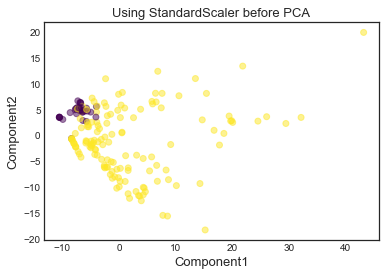

In [53]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using StandardScaler before PCA',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

#### How does it look in 3D

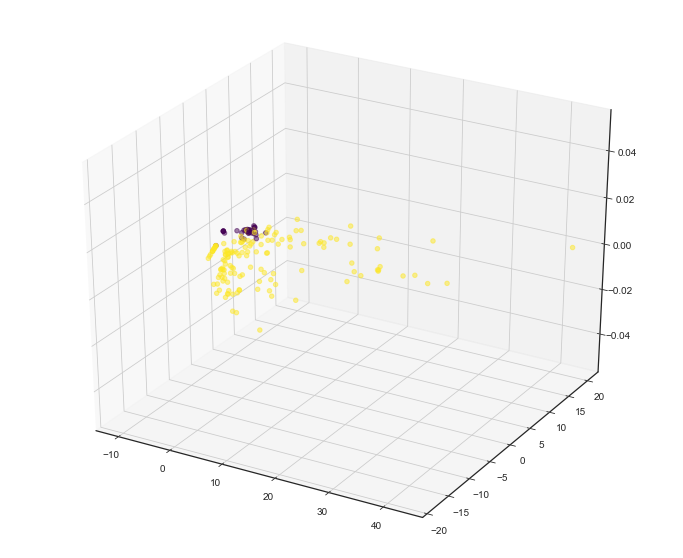

In [54]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

##  SVD

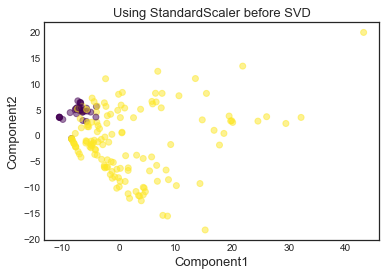

In [55]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using StandardScaler before SVD',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

#### SVD is same as PCA

#### Lets check how data looks if we do min max scaling and then PCA

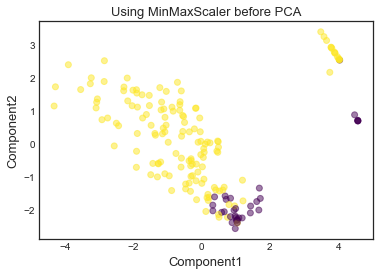

In [56]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using MinMaxScaler before PCA',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

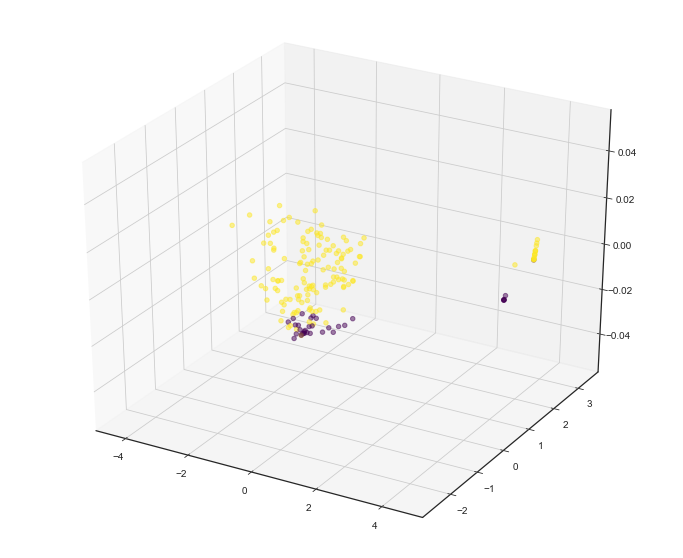

In [57]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

#### SVD with minmaxscaling

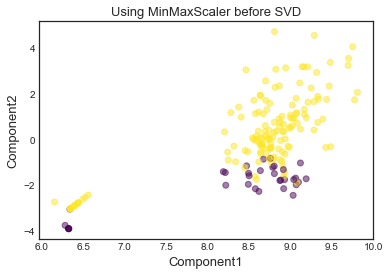

In [58]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using MinMaxScaler before SVD',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

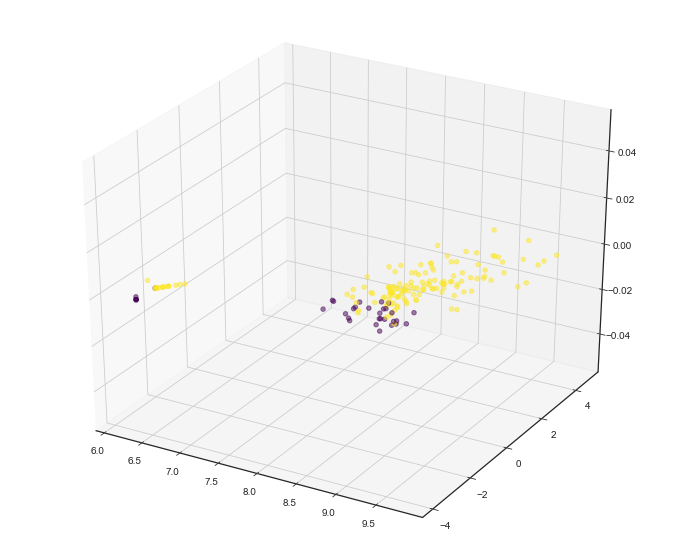

In [59]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

In [60]:
#Utility function to perform clustering with different algos, dimensionality reduction, different number of components
def testFunctions(algo,scaling,drTechnique,dimensions,X,y_arr):
    if scaling == 'Standard':
        scaler = StandardScaler()
    elif scaling == 'MinMax':
        scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(X)
    scaled_df = pd.DataFrame(scaled_df)
    
    if drTechnique == 'PCA':
        pca = PCA(n_components=dimensions)  
        X_pca = pca.fit_transform(scaled_df)
    elif drTechnique == 'SVD':
        pca = TruncatedSVD(n_components=dimensions)  
        X_pca = pca.fit_transform(scaled_df)
        
    if algo == 'KMeans':
        model = KMeans(n_clusters=2,n_init=100,random_state=42,precompute_distances=True,max_iter=1000)
    elif algo == 'AggClustering':
        model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
        
    model.fit(X_pca)
    y_pred = model.labels_
    score = f1_score(y_pred,y_arr,average='weighted')
    return score

## K Means

lets check f1 scores for different number of principal components

[0.38799432602934036, 0.3670237784165142, 0.3369180715764567, 0.33916094412548314, 0.33916094412548314, 0.3369180715764567, 0.3439586377430594, 0.3670237784165142, 0.6466898954703832, 0.3670237784165142, 0.3670237784165142, 0.3670237784165142, 0.3415084806928907, 0.3415084806928907, 0.3415084806928907]


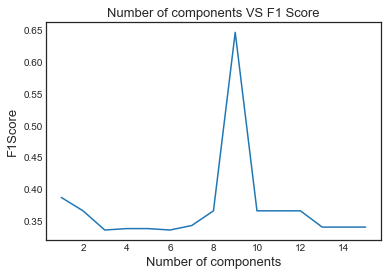

In [61]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','Standard','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.24111963426776425, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.7818018018018017, 0.7818018018018017, 0.7818018018018017, 0.7818018018018017, 0.7818018018018017]


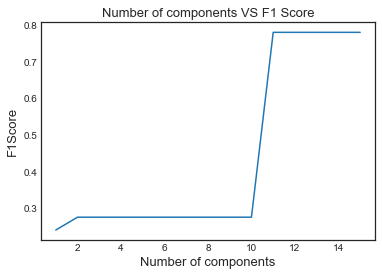

In [62]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','MinMax','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.27620353662937563, 0.19356499356499357, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.7818018018018017, 0.7818018018018017, 0.7818018018018017, 0.7818018018018017]


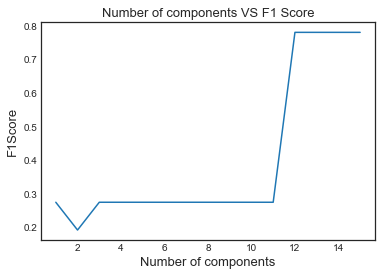

In [63]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','MinMax','SVD',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

#### Best results for K Means 

             precision    recall  f1-score   support

          0       0.29      0.18      0.22        33
          1       0.82      0.89      0.86       142

avg / total       0.72      0.76      0.74       175



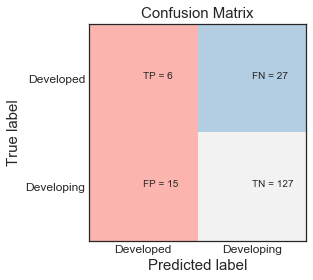

In [64]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=12)  
X_pca = pca.fit_transform(scaled_df)
model = KMeans(n_clusters=2,n_init=100,random_state=42,precompute_distances=True,max_iter=1000)
model.fit(X_pca)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

#### Lets see how did K-Means clustering performed and compare original points vs predicted points

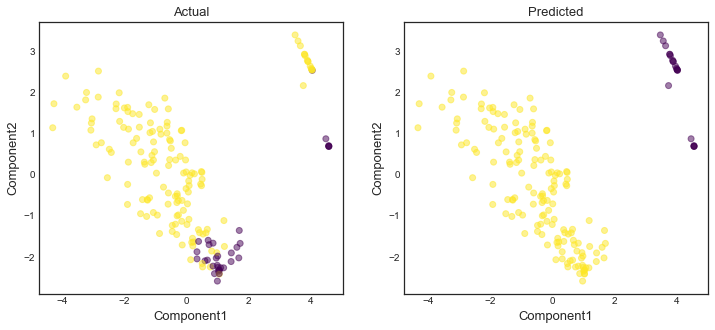

In [65]:
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Actual',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)

plt.subplot(1,2,2)
plt.scatter(a,b,alpha=0.5,c=y_pred,cmap='viridis')
plt.title('Predicted',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

## Agglomerative Clustering

[0.33478195488721807, 0.33275473579731213, 0.34915887151088826, 0.3415084806928907, 0.33478195488721807, 0.3638209116833051, 0.3607058823529412, 0.3607058823529412, 0.33478195488721807, 0.3607058823529412, 0.33478195488721807, 0.3290358168282989, 0.3290358168282989, 0.3290358168282989, 0.3607058823529412]


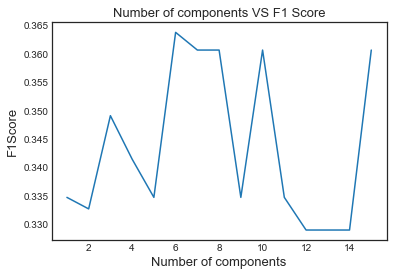

In [66]:
# Standardscaling + PCA
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','Standard','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563]


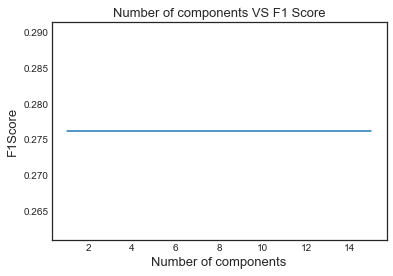

In [67]:
## MinMaxScaling + PCA
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','MinMax','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.27620353662937563, 0.4712878044618863, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563, 0.27620353662937563]


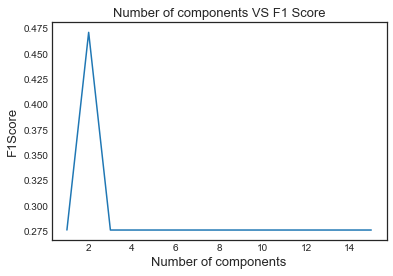

In [68]:
# MinMax Scaling + SVD
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','MinMax','SVD',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

#### Using best parameters for Agg clustering

             precision    recall  f1-score   support

          0       0.53      0.77      0.63        35
          1       0.96      0.88      0.92       206

avg / total       0.90      0.87      0.88       241



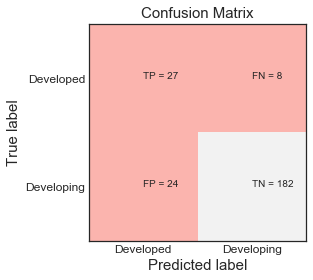

In [86]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(X_pca)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

#### Lets see how did Agglomerative clustering performed and compare original points vs predicted points

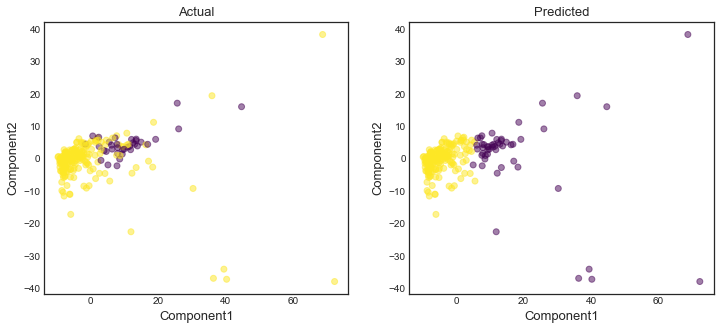

In [87]:
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Actual',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)

plt.subplot(1,2,2)
plt.scatter(a,b,alpha=0.5,c=y_pred,cmap='viridis')
plt.title('Predicted',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()